## Import library

In [15]:
%run bert
%run utils.ipynb
%run feat
import re
import string
import numpy as np
import pandas as pd
import sklearn as sk 
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score,mean_absolute_error,mean_squared_error,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from lingfeat import extractor

## For plotting

In [3]:
sns.set_theme(style='darkgrid')

## Load Data

In [5]:
loader = DataLoader()
d = loader.GetData('ASAP')
d = d.loc[d['essay_set'] ==2]
d.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
1783,2978,2,Certain materials being removed from libraries...,4.0,4.0,NaN,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,2979,2,Write a persuasive essay to a newspaper reflec...,1.0,2.0,NaN,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,2980,2,Do you think that libraries should remove cert...,2.0,3.0,NaN,2.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1786,2981,2,"In @DATE1's world, there are many things found...",4.0,4.0,NaN,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1787,2982,2,In life you have the 'offensive things'. The l...,4.0,4.0,NaN,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### descriptive

In [6]:
d['domain1_score'].describe()

count    1800.000000
mean        3.415556
std         0.774512
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: domain1_score, dtype: float64

In [8]:
tcount = []
i=0
for e in d['essay']:
    i+= 1
    if i %100 == 0:
        print(i)
    ext = extractor.pass_text(e)
    f = ext.preprocess()
    tcount.append(f['n_token'])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [9]:
d['token'] = tcount
d['token'].describe()

count    1800.000000
mean      289.683333
std       119.218545
min        23.000000
25%       210.750000
50%       281.500000
75%       357.000000
max       829.000000
Name: token, dtype: float64

<AxesSubplot: xlabel='token', ylabel='Count'>

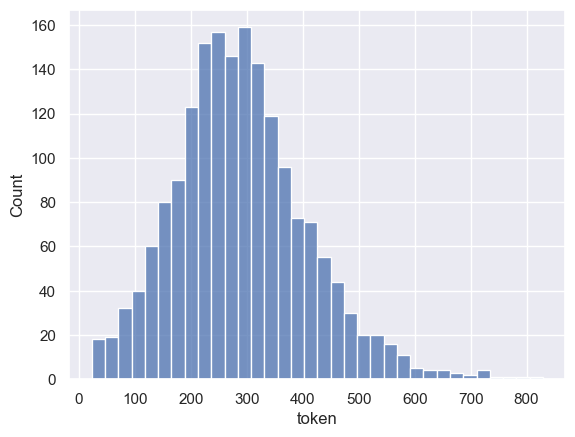

In [10]:
sns.histplot(d['token'])

Text(0.5, 0, 'score')

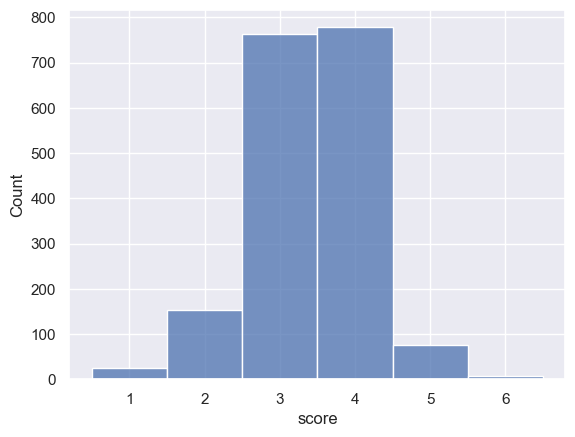

In [12]:
g = sns.histplot(d['domain1_score'],discrete=True)
g.set_xlabel('score')

## Embeddings
10m52s

In [13]:
EmbeddingFetcher = GetBERTEmbeddings(d['essay'],'model/deberta-v3-large')
EmbeddingFetcher.inf(stop=1500,SeqLen = 512 )

tokenized
0/1500, run:0
10/1500, run:0
20/1500, run:0
30/1500, run:0
40/1500, run:0
50/1500, run:0
60/1500, run:0
70/1500, run:0
80/1500, run:0
90/1500, run:0
100/1500, run:0
110/1500, run:0
120/1500, run:0
130/1500, run:0
140/1500, run:0
150/1500, run:0
160/1500, run:0
170/1500, run:0
180/1500, run:0
190/1500, run:0
200/1500, run:0
210/1500, run:0
220/1500, run:0
230/1500, run:0
240/1500, run:0
250/1500, run:0
260/1500, run:0
270/1500, run:0
280/1500, run:0
290/1500, run:0
300/1500, run:0
310/1500, run:0
320/1500, run:0
330/1500, run:0
340/1500, run:0
350/1500, run:0
360/1500, run:0
370/1500, run:0
380/1500, run:0
390/1500, run:0
400/1500, run:0
410/1500, run:0
420/1500, run:0
430/1500, run:0
440/1500, run:0
450/1500, run:0
460/1500, run:0
470/1500, run:0
480/1500, run:0
490/1500, run:0
500/1500, run:0
510/1500, run:0
520/1500, run:0
530/1500, run:0
540/1500, run:0
550/1500, run:0
560/1500, run:0
570/1500, run:0
580/1500, run:0
590/1500, run:0
600/1500, run:0
610/1500, run:0
620/1500,

In [5]:
del EmbeddingFetcher.model
torch.cuda.empty_cache()

In [32]:
x = EmbeddingFetcher.GetEmbeddings('CLS')

In [33]:
x = [np.array(i).reshape(1024) for i in x]
TrainX,TestX = np.array(x[:1400]),np.array(x[1400:])

## Train Y

In [14]:
le = LabelEncoder()
le.fit(d['domain1_score'])
y = le.transform(d['domain1_score']) 
TrainY,TestY = y[:1400],y[1400:]

## Embedding only

In [34]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.67
0.6561814191660571


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

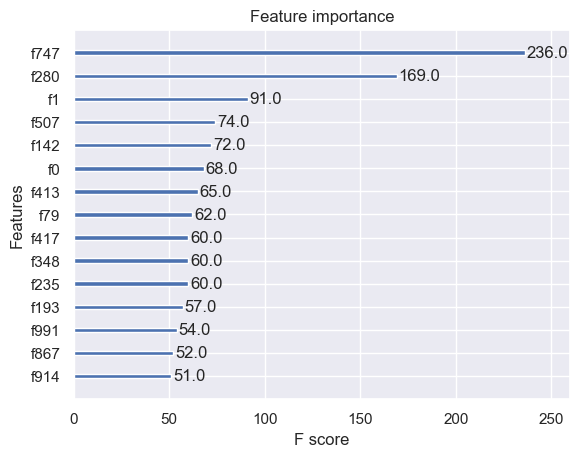

In [35]:
xgb.plot_importance(model,max_num_features=15)

Text(47.25, 0.5, 'True Label')

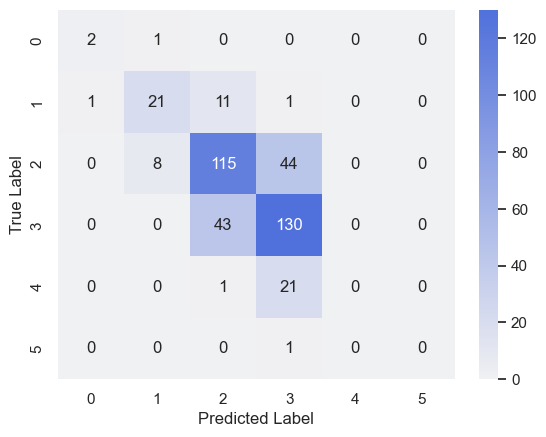

In [50]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')

### MeanP

In [29]:
x = EmbeddingFetcher.GetEmbeddings('MeanP')

In [30]:
x = [np.array(i).reshape(1024) for i in x]
TrainX,TestX = np.array(x[:1400]),np.array(x[1400:])

In [31]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.6625
0.6298241008138619


## Complexity
233m8.2s

In [ ]:
x1 = []
c= 0
for essay in d['essay']:
    ext = FeatureExtraction(essay)
    i = ext.GetFine()
    c += 1
    x1.append(i)
    if c % 10 == 0:
        print(c)
    with open('c.txt','a') as f:
        f.write(','.join([str(s) for s in i]))
        f.write('\n')

In [16]:
x1 = []
with open('c.txt') as f:
    for l in f.readlines():
        feat = [float(i) for i in l.split(',')]
        x1.append(feat)

### Fine only

In [55]:
TrainX,TestX = x1[:1400],x1[1400:]

In [56]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.615
0.5472810072327887


Text(47.25, 0.5, 'True Label')

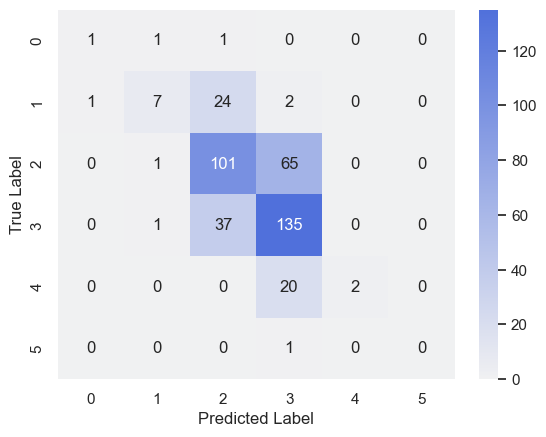

In [57]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

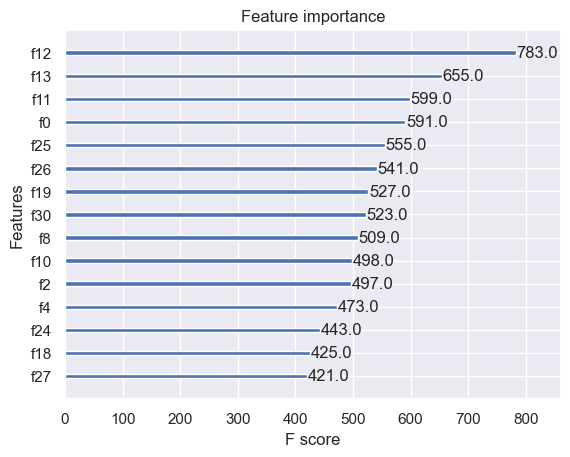

In [58]:
xgb.plot_importance(model,max_num_features=15)

### Fine+emb

In [51]:
x2 = []
for i in range(1800):
    a = np.concatenate((x[i],x1[i]))
    x2.append(a)
TrainX,TestX = x2[:1400],x2[1400:]

In [52]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.6875
0.667556418345062


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

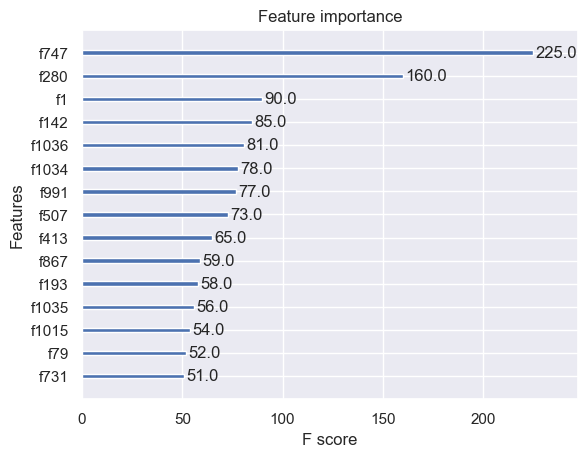

In [53]:
xgb.plot_importance(model,max_num_features=15)

Text(47.25, 0.5, 'True Label')

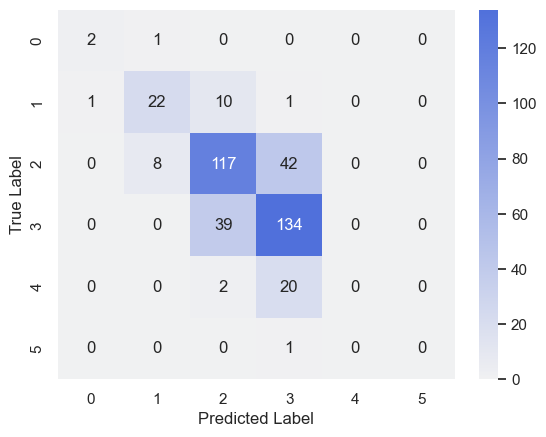

In [54]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')

### L2

In [19]:
with open('a1.txt') as f:
    l2 = f.readlines()[1:]
xl = dict()
for l in l2:
    i = int(l.split(',')[0].split('.')[0])
    feat = l.rstrip('\n').split(',')[-14:]
    feat = [float(s) for s in feat]
    xl[i] = feat
x4 = []
for i in range(1800):
    x4.append(xl[i])

In [20]:
TrainX,TestX = x4[:1400],x4[1400:]

In [21]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.5625
0.39884997386304233


### emb+l2

In [21]:
x5 = []
for i in range(1800):
    a = np.concatenate((x[i],x4[i]))
    x5.append(a)
TrainX,TestX = x5[:1400],x5[1400:]

In [22]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.67
0.6566837107377648


### Human

In [28]:
cohen_kappa_score(d['rater1_domain1'],d['rater2_domain1'],weights='quadratic')

0.8141252481412525